In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#忽略警告信息
import warnings
warnings.filterwarnings('ignore')

# 数据预处理

In [17]:
#读取数据
df = pd.read_csv("Mall_Customers.csv")
#查看数据情况
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


In [18]:
#去除重复值
df.drop_duplicates(inplace = True)
# 将性别变量数值化
gender_dic = {"Female":0,"Male":1}
df["Gender"] = df["Gender"].map(gender_dic)
print(df.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1       1   19                  15                      39
1           2       1   21                  15                      81
2           3       0   20                  16                       6
3           4       0   23                  16                      77
4           5       0   31                  17                      40


# 列变量相关性分析

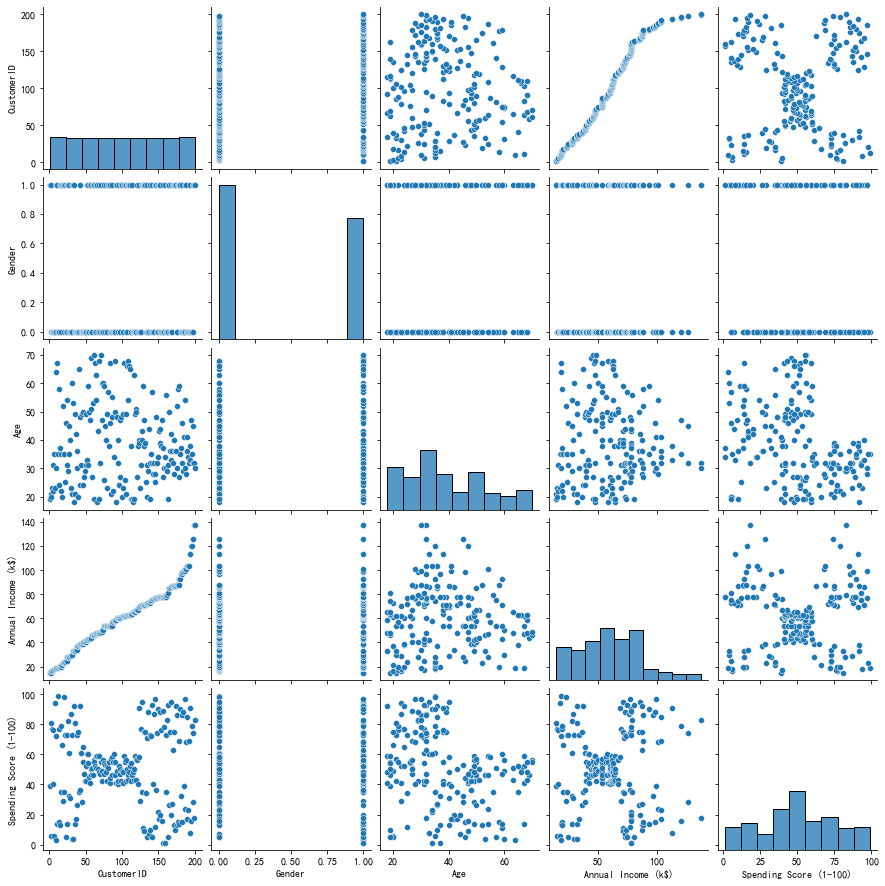

In [19]:
# 可视化变量之间的相关性
sns.pairplot(df) # 变量之间不存在明显的相关性

In [20]:
# 计算性别和消费得分之间点二列相关系数
from scipy import stats
print(stats.pointbiserialr(df["Gender"],df["Spending Score (1-100)"]))
# 结果表明二者不具有明显的相关性，聚类时排除性别字段

PointbiserialrResult(correlation=-0.05810873926162083, pvalue=0.4137446589852335)


In [21]:
# 选取特征进行聚类
data = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]]
print(data.head())

   Age  Annual Income (k$)  Spending Score (1-100)
0   19                  15                      39
1   21                  15                      81
2   20                  16                       6
3   23                  16                      77
4   31                  17                      40


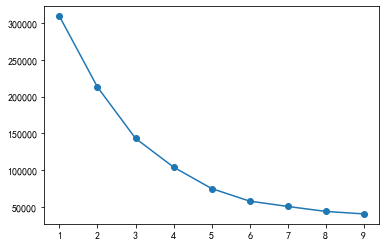

In [22]:
#根据手肘法则选取最佳聚类数
from sklearn.cluster import KMeans
SSE = []#利用误差平方和求最佳聚类数
for i in range(1,10):
    # init:初始化方法；
    # max_iter：执行一次k-means算法所进行的最大迭代数；
    km=KMeans(n_clusters=i, init = "k-means++", random_state=0)
    km.fit(data)
    SSE.append(km.inertia_)
plt.plot(range(1,10), SSE, "o-") #圆圈+线标记

<AxesSubplot:xlabel='col1', ylabel='col2'>

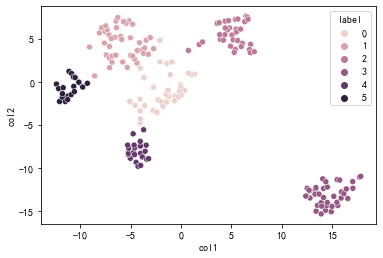

In [23]:
# 使用TSNE降维可视化聚类结果
from sklearn.manifold import TSNE

#设定聚类数为6
km_model = KMeans(n_clusters=6, init = "k-means++", random_state=0)
km_model.fit(data)
labels = km_model.labels_

tsne = TSNE()
t_data = tsne.fit_transform(data) # 将数据降成两维
tsne_df = pd.DataFrame(t_data,columns=["col1","col2"])
tsne_df["label"] = labels
sns.scatterplot(x = "col1",y="col2",hue="label",data=tsne_df) #hue类别

In [24]:
# 使用轮廓系数评估聚类效果
from sklearn import metrics
score = metrics.silhouette_score(data,labels)
print("聚类个数为6时，轮廓系数为：", score)

聚类个数为6时，轮廓系数为： 0.4523443947724053


[[27.         56.65789474 49.13157895]
 [56.15555556 53.37777778 49.08888889]
 [41.68571429 88.22857143 17.28571429]
 [32.69230769 86.53846154 82.12820513]
 [25.27272727 25.72727273 79.36363636]
 [44.14285714 25.14285714 19.52380952]]


<AxesSubplot:>

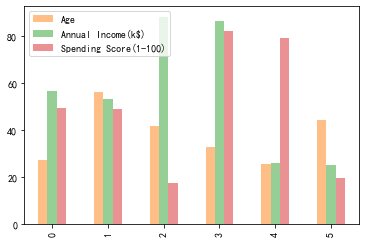

In [25]:
# 聚类人群可视化分析
cluster_centers=km_model.cluster_centers_
print(cluster_centers)
result = pd.DataFrame(data=cluster_centers,
                      columns = ["Age", "Annual Income(k$)","Spending Score(1-100)"]).reset_index(drop= True) #删除原行索引
#result.plot(kind="bar",color=["b1","b2","b3"],clip_on=False,alpha = 0.5)
result.plot(kind="bar",color=["C1","C2","C3"],clip_on=False,alpha = 0.5)


<AxesSubplot:ylabel='label'>

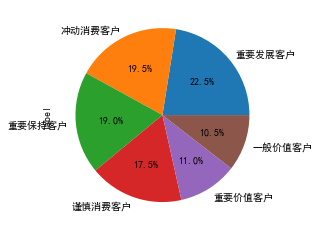

In [26]:
# 不同客户群体占比可视化
data["label"] = km_model.labels_
data["label"].value_counts().plot.pie(labels = ["重要发展客户","冲动消费客户","重要保持客户",
                                                "谨慎消费客户","重要价值客户","一般价值客户"],autopct="%.1f%%")